In [ ]:
{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Week 7 — N-Armed Bandit (ε-greedy)\n",
    "\n",
    "This notebook implements the 10-armed bandit experiment from Week 7 and compares:\n",
    "- Sample-average ε-greedy (updates with 1/n)\n",
    "- Constant-step-size ε-greedy (updates with fixed α)\n",   "\n",
    "It runs both **stationary** and **non-stationary** variants and plots:\n",
    "- Average reward vs time\n",
    "- % optimal action vs time\n"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "%matplotlib inline\n",
    "import numpy as np\n",
    "import matplotlib.pyplot as plt\n",
    "from time import time\n",
    "np.random.seed(42)\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Environment and helper functions"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "class NArmedBandit:\n",
    "    def __init__(self, k=10, stationary=True, initial_mean=0.0, walk_std=0.01):\n",
    "        self.k = k\n",
    "        self.q_true = np.random.randn(k) + initial_mean\n",
    "        self.stationary = stationary\n",
    "        self.walk_std = walk_std\n",
    "    def step(self, action):\n",
    "        reward = np.random.randn() + self.q_true[action]\n",
    "        optimal = int(np.argmax(self.q_true))\n",
    "        if not self.stationary:\n",
    "            self.q_true += np.random.normal(0, self.walk_std, size=self.k)\n",
    "        return reward, optimal\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Experiment runner\n",
    "`run_experiment` returns average rewards and % optimal action over time for two agents."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "def run_experiment(k=10, runs=100, steps=5000, eps=0.1, alpha=0.1, stationary=True):\n",
    "    avg_rewards = np.zeros((2, steps))\n",
    "    pct_optimal = np.zeros((2, steps))\n",
    "    t0 = time()\n",
    "    for run in range(runs):\n",
    "        env1 = NArmedBandit(k=k, stationary=stationary, walk_std=0.01)\n",
    "        env2 = NArmedBandit(k=k, stationary=stationary, walk_std=0.01)\n",
    "        Q1 = np.zeros(k)\n",
    "        Q2 = np.zeros(k)\n",
    "        N1 = np.zeros(k, dtype=int)\n",
    "        rewards1 = np.zeros(steps)\n",
    "        rewards2 = np.zeros(steps)\n",
    "        optimal1 = np.zeros(steps)\n",
    "        optimal2 = np.zeros(steps)\n",
    "        for t in range(steps):\n",
    "            # agent1: sample-average epsilon-greedy\n",
    "            if np.random.rand() < eps:\n",
    "                a1 = np.random.randint(k)\n",
    "            else:\n",
    "                a1 = int(np.argmax(Q1))\n",
    "            r1, opt1 = env1.step(a1)\n",
    "            N1[a1] += 1\n",
    "            Q1[a1] += (r1 - Q1[a1]) / N1[a1]\n",
    "            rewards1[t] = r1\n",
    "            optimal1[t] = 1 if a1 == opt1 else 0\n",
    "            # agent2: constant-step epsilon-greedy\n",
    "            if np.random.rand() < eps:\n",
    "                a2 = np.random.randint(k)\n",
    "            else:\n",
    "                a2 = int(np.argmax(Q2))\n",
    "            r2, opt2 = env2.step(a2)\n",
    "            Q2[a2] += alpha * (r2 - Q2[a2])\n",
    "            rewards2[t] = r2\n",
    "            optimal2[t] = 1 if a2 == opt2 else 0\n",
    "        avg_rewards[0] += rewards1\n",
    "        avg_rewards[1] += rewards2\n",
    "        pct_optimal[0] += optimal1\n",
    "        pct_optimal[1] += optimal2\n",
    "    avg_rewards /= runs\n",
    "    pct_optimal = (pct_optimal / runs) * 100.0\n",
    "    print(f\"Experiment finished in {time()-t0:.1f}s (runs={runs}, steps={steps})\")\n",
    "    return avg_rewards, pct_optimal\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Run experiments (stationary and non-stationary)\n",
    "You can change `runs`, `steps`, `eps`, `alpha` to match assignment requirements.\n",
    "**Note:** `steps=10000` and `runs=200` is the full-scale setting but may take a long time depending on your machine."
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "# Parameters\n",
    "k = 10\n",
    "runs = 100     # increase for smoother curves (try 200 for assignment)\n",
    "steps = 5000   # increase to 10000 for full experiment\n",
    "eps = 0.1\n",
    "alpha = 0.1\n",
    "# Run\n",
    "print(\"Running stationary experiment...\")\n",
    "avg_rewards_stat, pct_opt_stat = run_experiment(k=k, runs=runs, steps=steps, eps=eps, alpha=alpha, stationary=True)\n",
    "print(\"Running non-stationary experiment...\")\n",
    "avg_rewards_nonstat, pct_opt_nonstat = run_experiment(k=k, runs=runs, steps=steps, eps=eps, alpha=alpha, stationary=False)\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Plots — 2×2 layout (all 4 graphs together)"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "t = np.arange(1, steps+1)\n",
    "fig, axs = plt.subplots(2, 2, figsize=(14,9), constrained_layout=True)\n",
    "# Stationary - Avg reward\n",
    "axs[0,0].plot(t, avg_rewards_stat[0], label=f'Sample-avg (eps={eps})')\n",
    "axs[0,0].plot(t, avg_rewards_stat[1], label=f'Const-step (alpha={alpha})')\n",
    "axs[0,0].set_title('Average Reward (Stationary)')\n",
    "axs[0,0].set_xlabel('Time steps'); axs[0,0].set_ylabel('Average reward')\n",
    "axs[0,0].legend(); axs[0,0].grid(True)\n",
    "# Stationary - % optimal\n",
    "axs[0,1].plot(t, pct_opt_stat[0], label='Sample-avg')\n",
    "axs[0,1].plot(t, pct_opt_stat[1], label='Const-step')\n",
    "axs[0,1].set_title('% Optimal Action (Stationary)')\n",
    "axs[0,1].set_xlabel('Time steps'); axs[0,1].set_ylabel('% Optimal action')\n",
    "axs[0,1].legend(); axs[0,1].grid(True)\n",
    "# Non-stationary - Avg reward\n",
    "axs[1,0].plot(t, avg_rewards_nonstat[0], label=f'Sample-avg (eps={eps})')\n",
    "axs[1,0].plot(t, avg_rewards_nonstat[1], label=f'Const-step (alpha={alpha})')\n",
    "axs[1,0].set_title('Average Reward (Non-stationary)')\n",
    "axs[1,0].set_xlabel('Time steps'); axs[1,0].set_ylabel('Average reward')\n",
    "axs[1,0].legend(); axs[1,0].grid(True)\n",
    "# Non-stationary - % optimal\n",
    "axs[1,1].plot(t, pct_opt_nonstat[0], label='Sample-avg')\n",
    "axs[1,1].plot(t, pct_opt_nonstat[1], label='Const-step')\n",
    "axs[1,1].set_title('% Optimal Action (Non-stationary)')\n",
    "axs[1,1].set_xlabel('Time steps'); axs[1,1].set_ylabel('% Optimal action')\n",
    "axs[1,1].legend(); axs[1,1].grid(True)\n",
    "plt.show()\n",
    "# Optionally save figure\n",
    "fig.savefig('bandit_2x2.png', dpi=200)\n",
    "print('Saved bandit_2x2.png')\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Final statistics and brief interpretation"
   ]
  },
  {
   "cell_type": "code",
   "metadata": {},
   "source": [
    "print('Final stats:')\n",
    "print('Stationary - Final avg rewards: sample-avg={:.4f}, const-step={:.4f}'.format(avg_rewards_stat[0,-1], avg_rewards_stat[1,-1]))\n",
    "print('Stationary - Final % optimal: sample-avg={:.2f}%, const-step={:.2f}%'.format(pct_opt_stat[0,-1], pct_opt_stat[1,-1]))\n",
    "print('Non-stationary - Final avg rewards: sample-avg={:.4f}, const-step={:.4f}'.format(avg_rewards_nonstat[0,-1], avg_rewards_nonstat[1,-1]))\n",
    "print('Non-stationary - Final % optimal: sample-avg={:.2f}%, const-step={:.2f}%'.format(pct_opt_nonstat[0,-1], pct_opt_nonstat[1,-1]))\n"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "---\n",
    "### Notes for submission / viva:\n",
    "- Increase `runs` to 200 and `steps` to 10000 for smoother and assignment-scale results.\n",
    "- Explain why sample-average works well in stationary problems and constant-step (α) is better for non-stationary (it tracks changes).\n",
    "- You may add experiments with different ε (0.01, 0.1, 0.2) and plot heatmap/table of final average reward.\n"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "name": "python",
   "version": "3.x"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 5
}


{'cells': [{'cell_type': 'markdown',
   'metadata': {},
   'source': ['# Week 7 — N-Armed Bandit (ε-greedy)\n',
    '\n',
    'This notebook implements the 10-armed bandit experiment from Week 7 and compares:\n',
    '- Sample-average ε-greedy (updates with 1/n)\n',
    '- Constant-step-size ε-greedy (updates with fixed α)\n',
    '\n',
    'It runs both **stationary** and **non-stationary** variants and plots:\n',
    '- Average reward vs time\n',
    '- % optimal action vs time\n']},
  {'cell_type': 'code',
   'metadata': {},
   'source': ['%matplotlib inline\n',
    'import numpy as np\n',
    'import matplotlib.pyplot as plt\n',
    'from time import time\n',
    'np.random.seed(42)\n']},
  {'cell_type': 'markdown',
   'metadata': {},
   'source': ['## Environment and helper functions']},
  {'cell_type': 'code',
   'metadata': {},
   'source': ['class NArmedBandit:\n',
    '    def __init__(self, k=10, stationary=True, initial_mean=0.0, walk_std=0.01):\n',
    '        self.k = k\n

Finished experiment (runs=50, steps=2000) in 3.34s
Finished experiment (runs=50, steps=2000) in 2.35s


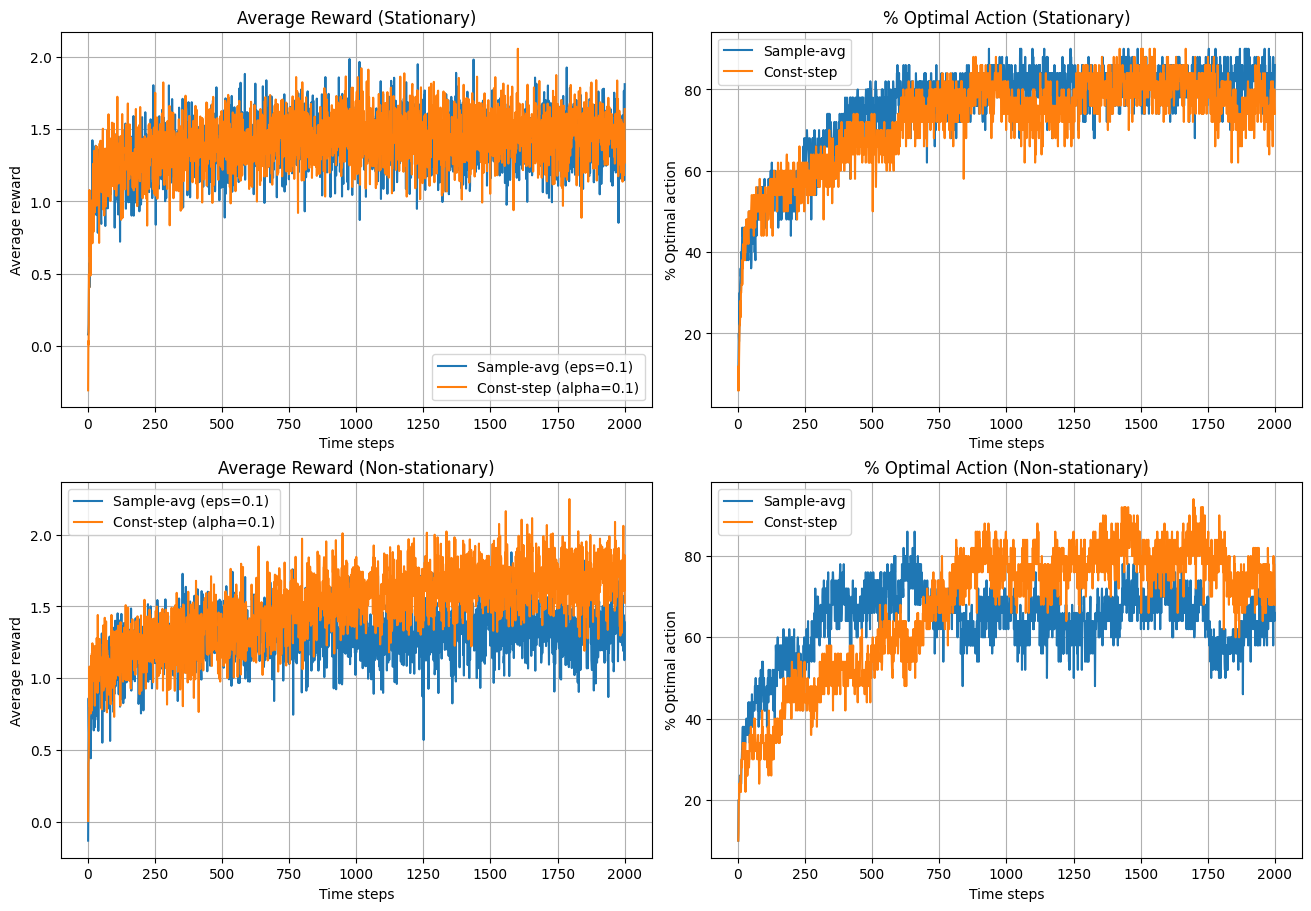

Saved bandit_2x2_demo.png


In [ ]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

np.random.seed(42)

# Lightweight bandit implementation (fast enough to run here)
class NArmedBandit:
    def __init__(self, k=10, stationary=True, walk_std=0.01):
        self.k = k
        self.q_true = np.random.randn(k)
        self.stationary = stationary
        self.walk_std = walk_std
    def step(self, action):
        reward = np.random.randn() + self.q_true[action]
        optimal = int(np.argmax(self.q_true))
        if not self.stationary:
            self.q_true += np.random.normal(0, self.walk_std, size=self.k)
        return reward, optimal

def run_experiment(k=10, runs=50, steps=2000, eps=0.1, alpha=0.1, stationary=True):
    # smaller runs/steps to show plots quickly; increase if you want smoother curves
    avg_rewards = np.zeros((2, steps))
    pct_optimal = np.zeros((2, steps))
    t0 = time()
    for run in range(runs):
        env1 = NArmedBandit(k=k, stationary=stationary, walk_std=0.01)
        env2 = NArmedBandit(k=k, stationary=stationary, walk_std=0.01)
        Q1 = np.zeros(k)
        Q2 = np.zeros(k)
        N1 = np.zeros(k, dtype=int)
        rewards1 = np.zeros(steps)
        rewards2 = np.zeros(steps)
        optimal1 = np.zeros(steps)
        optimal2 = np.zeros(steps)
        for t in range(steps):
            # agent1: sample-average epsilon-greedy
            if np.random.rand() < eps:
                a1 = np.random.randint(k)
            else:
                a1 = int(np.argmax(Q1))
            r1, opt1 = env1.step(a1)
            N1[a1] += 1
            Q1[a1] += (r1 - Q1[a1]) / N1[a1]
            rewards1[t] = r1
            optimal1[t] = 1 if a1 == opt1 else 0
            # agent2: constant-step epsilon-greedy
            if np.random.rand() < eps:
                a2 = np.random.randint(k)
            else:
                a2 = int(np.argmax(Q2))
            r2, opt2 = env2.step(a2)
            Q2[a2] += alpha * (r2 - Q2[a2])
            rewards2[t] = r2
            optimal2[t] = 1 if a2 == opt2 else 0
        avg_rewards[0] += rewards1
        avg_rewards[1] += rewards2
        pct_optimal[0] += optimal1
        pct_optimal[1] += optimal2
    avg_rewards /= runs
    pct_optimal = (pct_optimal / runs) * 100.0
    print(f"Finished experiment (runs={runs}, steps={steps}) in {time()-t0:.2f}s")
    return avg_rewards, pct_optimal

# Parameters (adjust if you want)
k = 10
runs = 50       # quick demonstration; set to 200 for final experiment
steps = 2000    # quick demonstration; set to 10000 for final experiment
eps = 0.1
alpha = 0.1

# Run both stationary and non-stationary experiments
avg_rewards_stat, pct_opt_stat = run_experiment(k=k, runs=runs, steps=steps, eps=eps, alpha=alpha, stationary=True)
avg_rewards_nonstat, pct_opt_nonstat = run_experiment(k=k, runs=runs, steps=steps, eps=eps, alpha=alpha, stationary=False)

# Plot all four graphs in a 2x2 grid
t = np.arange(1, steps+1)
fig, axs = plt.subplots(2, 2, figsize=(13,9), constrained_layout=True)

axs[0,0].plot(t, avg_rewards_stat[0], label=f'Sample-avg (eps={eps})')
axs[0,0].plot(t, avg_rewards_stat[1], label=f'Const-step (alpha={alpha})')
axs[0,0].set_title('Average Reward (Stationary)')
axs[0,0].set_xlabel('Time steps'); axs[0,0].set_ylabel('Average reward')
axs[0,0].legend(); axs[0,0].grid(True)

axs[0,1].plot(t, pct_opt_stat[0], label='Sample-avg')
axs[0,1].plot(t, pct_opt_stat[1], label='Const-step')
axs[0,1].set_title('% Optimal Action (Stationary)')
axs[0,1].set_xlabel('Time steps'); axs[0,1].set_ylabel('% Optimal action')
axs[0,1].legend(); axs[0,1].grid(True)

axs[1,0].plot(t, avg_rewards_nonstat[0], label=f'Sample-avg (eps={eps})')
axs[1,0].plot(t, avg_rewards_nonstat[1], label=f'Const-step (alpha={alpha})')
axs[1,0].set_title('Average Reward (Non-stationary)')
axs[1,0].set_xlabel('Time steps'); axs[1,0].set_ylabel('Average reward')
axs[1,0].legend(); axs[1,0].grid(True)

axs[1,1].plot(t, pct_opt_nonstat[0], label='Sample-avg')
axs[1,1].plot(t, pct_opt_nonstat[1], label='Const-step')
axs[1,1].set_title('% Optimal Action (Non-stationary)')
axs[1,1].set_xlabel('Time steps'); axs[1,1].set_ylabel('% Optimal action')
axs[1,1].legend(); axs[1,1].grid(True)

plt.show()

# Save the figure (optional)
fig.savefig('bandit_2x2_demo.png', dpi=150)
print("Saved bandit_2x2_demo.png")
